In [21]:
# BLUERT demo
from bleurt import score

references = ["This is a test."]
candidates = ["This isn't a test."]

bleurt_scorer = score.BleurtScorer('../BLEURT-20')
scores = bleurt_scorer.score(references=references, candidates=candidates)
assert isinstance(scores, list) and len(scores) == 1
print(scores)

INFO:tensorflow:Reading checkpoint ../BLEURT-20.


INFO:tensorflow:Reading checkpoint ../BLEURT-20.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Will load checkpoint BLEURT-20


INFO:tensorflow:Will load checkpoint BLEURT-20


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:... name:BLEURT-20


INFO:tensorflow:... name:BLEURT-20


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... max_seq_length:512


INFO:tensorflow:... max_seq_length:512


INFO:tensorflow:... vocab_file:None


INFO:tensorflow:... vocab_file:None


INFO:tensorflow:... do_lower_case:None


INFO:tensorflow:... do_lower_case:None


INFO:tensorflow:... sp_model:sent_piece


INFO:tensorflow:... sp_model:sent_piece


INFO:tensorflow:... dynamic_seq_length:True


INFO:tensorflow:... dynamic_seq_length:True


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Will load model: ../BLEURT-20/sent_piece.model.


INFO:tensorflow:Will load model: ../BLEURT-20/sent_piece.model.


INFO:tensorflow:SentencePiece tokenizer created.


INFO:tensorflow:SentencePiece tokenizer created.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Loading model.


INFO:tensorflow:Loading model.


INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


[0.6768419742584229]


In [22]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm

file_path = 'Final Code/NEW_final_generated_responses_1000.csv'
data = pd.read_csv(file_path)
# Define Jaccard similarity function
def jaccard_similarity(doc1, doc2):
    words_doc1 = set(doc1.split()) 
    words_doc2 = set(doc2.split())
    intersection = words_doc1.intersection(words_doc2)
    union = words_doc1.union(words_doc2)
    return float(len(intersection)) / len(union)

# Define custom ROUGE-L function
def calculate_rouge_l(reference, candidate):
    reference_tokens = reference.split()
    candidate_tokens = candidate.split()
    reference_len = len(reference_tokens)
    candidate_len = len(candidate_tokens)
    
    dp = [[0] * (candidate_len + 1) for _ in range(reference_len + 1)]
    
    for i in range(reference_len + 1):
        for j in range(candidate_len + 1):
            if i == 0 or j == 0:
                dp[i][j] = 0
            elif reference_tokens[i-1] == candidate_tokens[j-1]:
                dp[i][j] = dp[i-1][j-1] + 1
            else:
                dp[i][j] = max(dp[i-1][j], dp[i][j-1])
                
    lcs_len = dp[reference_len][candidate_len]
    precision = lcs_len / candidate_len if candidate_len > 0 else 0
    recall = lcs_len / reference_len if reference_len > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return f1_score

# Vectorize text for cosine similarity
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data[['generated_response_prompt1', 'generated_response_prompt2', 'physician_comments']].values.flatten())

# Calculate cosine similarities
cosine_similarities = cosine_similarity(tfidf_matrix)
similarity_results = pd.DataFrame(data['id'], columns=['id'])

# Calculating all similarities
similarity_functions = [cosine_similarity, jaccard_similarity, sentence_bleu, calculate_rouge_l, bleurt_scorer.score]
labels = ['Cosine', 'Jaccard', 'BLEU', 'ROUGE_L', 'BLEURT']

# Calculate all pairwise comparisons
for func, label in tqdm(zip(similarity_functions, labels)):
    pairs = [('generated_response_prompt1', 'generated_response_prompt2'),
             ('generated_response_prompt1', 'physician_comments'),
             ('generated_response_prompt2', 'physician_comments')]
    
    for pair in pairs:
        col_name = f'{label}_Sim_{pair[0][-1]}_{pair[1][-1]}'
        if func == cosine_similarity:
            similarity_results[col_name] = [
                func(tfidf_vectorizer.transform([row[pair[0]]]), 
                     tfidf_vectorizer.transform([row[pair[1]]]))[0, 0]
                for index, row in data.iterrows()
            ]
        elif label == 'BLEURT':  # BLEURT scoring requires a slightly different approach
            similarity_results[col_name] = [
                func(references=[row[pair[0]]], candidates=[row[pair[1]]])[0]
                for index, row in data.iterrows()
            ]
        else:
            similarity_results[col_name] = [
                func(row[pair[0]], row[pair[1]])
                for index, row in data.iterrows()
            ]

similarity_results.head()

2it [00:03,  1.50s/it]/Users/dhirpalshah/miniconda3/envs/condavenv/lib/python3.8/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/dhirpalshah/miniconda3/envs/condavenv/lib/python3.8/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/dhirpalshah/miniconda3/envs/condavenv/lib/python3.8/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N

,id,Cosine_Sim_1_2,Cosine_Sim_1_s,Cosine_Sim_2_s,Jaccard_Sim_1_2,Jaccard_Sim_1_s,Jaccard_Sim_2_s,BLEU_Sim_1_2,BLEU_Sim_1_s,BLEU_Sim_2_s,ROUGE_L_Sim_1_2,ROUGE_L_Sim_1_s,ROUGE_L_Sim_2_s,BLEURT_Sim_1_2,BLEURT_Sim_1_s,BLEURT_Sim_2_s
0,1i7s0u,0.615637,0.147181,0.158438,0.260355,0.094463,0.108108,6.937001e-232,8.468579e-232,8.210873e-232,0.227477,0.068249,0.106870,0.482898,0.386397,0.413004
1,1i7qst,0.595062,0.276439,0.502346,0.247265,0.106250,0.103245,6.366011e-232,8.859356e-232,8.793483e-232,0.191529,0.088106,0.082409,0.492618,0.448725,0.449826
2,1i7hzo,0.454754,0.243526,0.293155,0.182254,0.078292,0.082803,6.509495e-232,9.405151e-232,9.526533e-232,0.147692,0.058158,0.076923,0.453372,0.441486,0.435190
3,1iawxh,0.424313,0.170060,0.221752,0.170604,0.068966,0.085911,7.104354e-232,8.187295e-232,8.324944e-232,0.144578,0.073365,0.097996,0.392633,0.415364,0.405747
4,1i9v7i,0.393324,0.216343,0.203745,0.154229,0.096573,0.127660,7.150224e-232,8.589594e-232,8.474271e-232,0.131579,0.075812,0.111111,0.499030,0.419665,0.467124


In [23]:
similarity_results.to_csv("Final Code/NEW_final_analysis.csv", index=False)

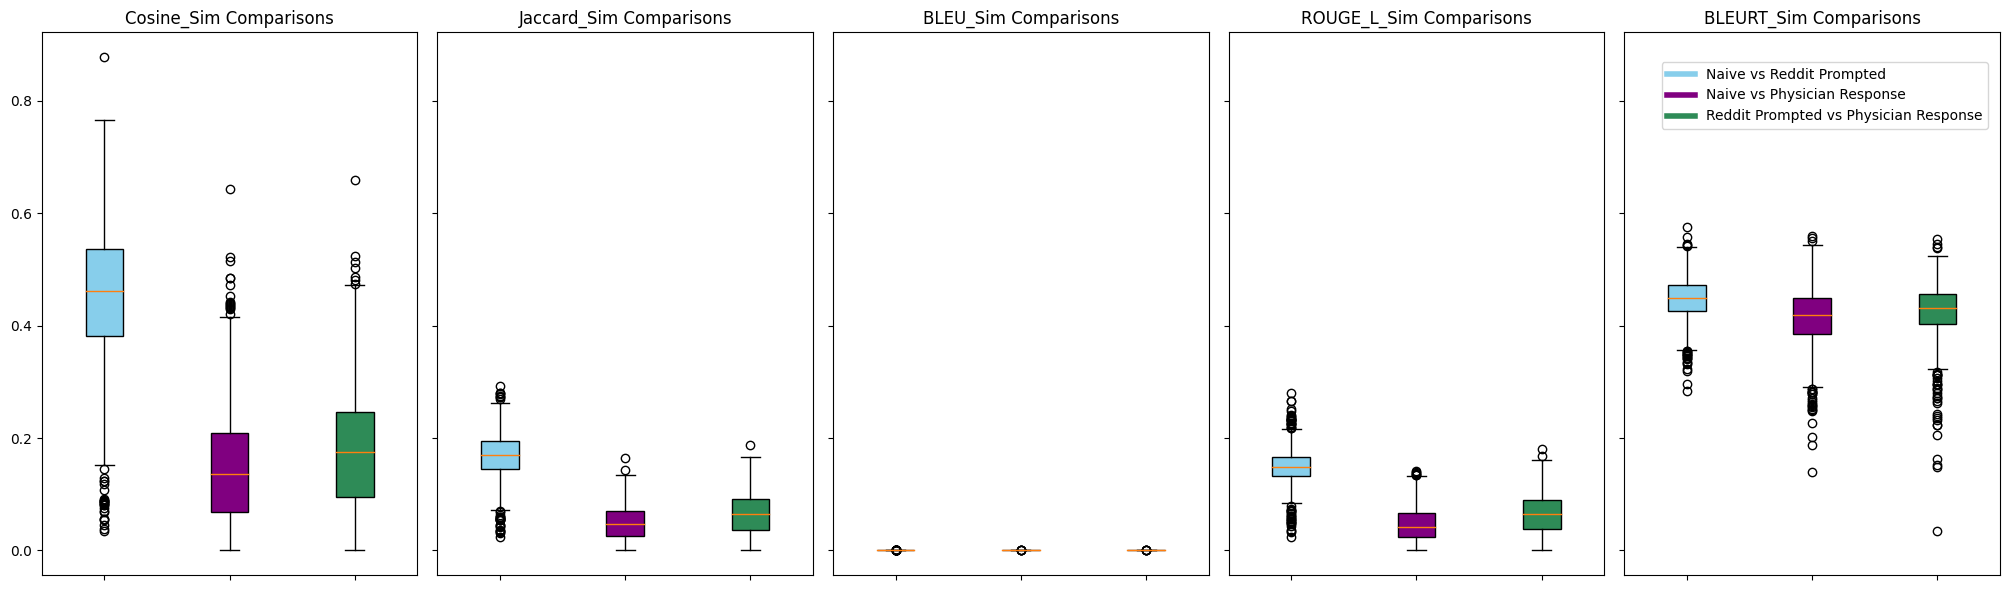

In [45]:
import matplotlib.pyplot as plt

data = pd.read_csv('Final Code/NEW_final_analysis.csv')
metrics = ['Cosine_Sim', 'Jaccard_Sim', 'BLEU_Sim', 'ROUGE_L_Sim', 'BLEURT_Sim']
comparisons = ['1_2', '1_s', '2_s']
legend_labels = ['Naive vs Reddit Prompted', 'Naive vs Physician Response', 'Reddit Prompted vs Physician Response']
# Set up the boxplot with specific colors for each box, add a legend, and remove x-axis labels
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6), sharey=True)

# Create a boxplot for each metric with specified colors, add a legend, and remove x-axis labels
for i, metric in enumerate(metrics):
    # Prepare data and colors for each comparison type for the current metric
    metric_data = [data[f"{metric}_{comp}"] for comp in comparisons]
    bplot = axes[i].boxplot(metric_data, patch_artist=True)
    
    # Apply colors to each box
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[i].set_title(f'{metric} Comparisons')
    axes[i].set_xticklabels([])  # Remove x-axis labels

# Add a custom legend to the figure
legend_patches = [plt.Line2D([0], [0], color=color, lw=4, label=label) for color, label in zip(colors, legend_labels)]
fig.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1, 0.9))

# Adjust layout and display the boxplots with legend
plt.tight_layout(rect=[0, 0, 1.01, 1])  # Adjust the right margin to fit the legend
plt.show()
